In [ ]:
# Bayesian Inference to form Probability Distributions of (hypothetical) NFL Kickers Accuracy, using:

* BeautifulSoup library for web scraping
* Pymc3 library for probabalistic programming

by Jesse Galef
January 2017

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
import pymc3 as pm

## Premise: Comparing two NFL kickers, one who made 178 of 200 kicks (89%), the other who made 19 of 20 (95%).

You're the chief data scientist of a foobtall team, and you're facing a difficult decision. You're in the head office with the general manager and the team owner, and you're getting ready to sign a new kicker to the team. His name is Matt Stover, and his agent boasts that he made 178 out of 200 field goals - 89%.

Suddenly, another agent waltzes in. "Wait!" he says. "I represent Billy Cundiff, the hot young kicker who's made 95% of his attempts. We're asking for the same amount Stover is, despite having a higher average. It's a steal!"

"Oh come on," says the first agent, rolling his eyes. "He made 95% because he's only taken 20 kicks and happened to make 19 of them. He got lucky and he's trying to cash in. 20 kicks probably tells us next to nothing! Stover is at least 5% better than most young kickers; I bet he's at least 3% better than Cundiff."

"Teams are always looking for the next great kicker. Are you looking for a great kicker, or just an acceptabe one?" asks Cundiff's agent. "You know what you're getting with Stover, but Cundiff has a chance to be great."

The general manager looks to you. "What do you think? Is making 19 out of 20 kicks enough evidence to conclude that young Cundiff is better than the established Stover? Or do we think he got lucky?"

What's your intuition?

### Three Questions:

A) General Manager's Question: How likely is Cundiff to be more accurate than Stover?

B) Stover's Agent's Claim: How likely is Stover to be at least 3% more accurate than Cundiff?

C) Cundiff's Agent's Claim: If having an accuracy of over 92% counts as great, how much more likely is Cundiff to be a 'great' kicker compared to Stover?

## Approach: 
1) Scrape and format data on rookie kicker accuracy from NFL.com from 1990 - 2016 using the BeautifulSoup library.

2) Form priors for rookie accuracy by modeling the distributions that would produce those observations.

3) Model the likelihood of different Stover/Cundiff accuracies generating our observations (178/200 and 19/20), starting with priors from step 2

4) Calculate the probability that:

    4A) the Cundiff has a higher true accuracy
    4B) the Stover is better by at least 3%
    4C) each kicker has an accuracy of over 92%

### Hypothesis testing isn't the best approach here

In [5]:
from scipy.stats import chi2_contingency

In [8]:
obs = pd.DataFrame([[178,22],[19,1]], columns=['Made','Missed'], index=['Stover','Cundiff'])
print obs
print 'Probability that the kickers would have been this different or more if they were equally good:', chi2_contingency(obs)[1]
# Since the p-value is .65, results this close are reasonably likely to be from equal distributions.  
# We can't reject this null hypothesis (that they're equally good kickers.)

         Made  Missed
Stover    178      22
Cundiff    19       1
Probability that the kickers would have been this different or more if they were equally good: 0.650601717192


## Get priors by scraping NFL data

In [9]:
from bs4 import BeautifulSoup
import urllib

In [10]:
cols=['Name','Team','Pos','Made','Attempted','Percent']

In [11]:
def get_url(year):
    url = "http://www.nfl.com/stats/categorystats?archive=false&conference=null&statisticPositionCategory=FIELD_GOAL_KICKER&season="
    url = url + str(year)
    url = url + "&seasonType=REG&experience=0&tabSeq=1&qualified=false&Submit=Go"
    return url

In [88]:
players = []
for year in range(1980,2017):
    url = get_url(year)
    season_stats_page = BeautifulSoup(urllib.urlopen(url).read(), 'lxml')
    rows = season_stats_page.find(id='result') #Returns the results of the query, a table of stats

    if rows != None: #If there are rookie kickers in this year...
        rows = rows.find_all('tr')

        for row in rows[2:]: # Ignore the first two rows, which are the headers
            player = {}
            player['year'] = year
            for cell, col in zip(row.find_all('td')[1:7], cols): # Take the first 7 cells and append their contents
                player[col] = cell.text.strip()
            players.append(player)

In [91]:
rookie_kickers = pd.DataFrame(players, columns=cols+['year'])
rookie_kickers.head()

,Name,Team,Pos,Made,Attempted,Percent,year
0,John Kasay,SEA,K,25,31,81,1991
1,Lin Elliott,DAL,K,24,35,69,1992
2,Jason Hanson,DET,K,21,26,81,1992
3,Jason Elam,DEN,K,26,35,74,1993
4,Doug Pelfrey,CIN,K,24,31,77,1993


In [92]:
rookie_kickers = rookie_kickers[rookie_kickers.Percent != '']
# Removes any rows where the rookie didn't actually attempt any kicks

In [93]:
for to_int in ['Made','Attempted','Percent']:
    rookie_kickers[to_int] = rookie_kickers[to_int].astype(int)

# Convert the text values to integers

In [96]:
rookie_kickers = rookie_kickers[rookie_kickers.Attempted >=20]
#Only take kickers who attempted at least 20 kicks 

In [97]:
rookie_kickers.to_csv('assets/rookie_kickers_20attempts.csv')

## Use the scraped data to form a prior accuracy distribution, and combine those with the observations to model the distribution of possible accuracies.

In [14]:
rookie_kickers = pd.read_csv('assets/rookie_kickers_20attempts.csv')

In [136]:
model = pm.Model()
with model:
    prior_mu = pm.Uniform('prior_mu',0.01,.999)
    prior_sd = pm.Uniform('prior_sd', 0.01,.5)
        # Draws a vaue for the prior's mu & standard deviation based on these distributions.
        # The distributions start as uniform, but respond to how the data compares to the 
        # observations (in the next step.)

    prior = pm.Beta('prior', mu=prior_mu, sd = prior_sd, observed=rookie_kickers.Percent/100.)
        # Cacuates the log-probability of seeing these observatins - the history of rookie 
        # season averages - with the vaues drawn from prior_mu and prior_sd distributions 
        # above. The distributions consider those values more likey or less based on how the 
        # odds compare to the odds of the previously chosen values.
    
    simulated = pm.Beta('simulated', mu=prior_mu, sd = prior_sd)
        # Since the 'prior' distribution has observatins, it doesn't generate samples of its 
        # own that we can look at. This gives us a way to look at the prior distribution 
        # that accuracy is drawn from.

    Stover_p = pm.Beta('Stover_p', mu=prior_mu, sd=prior_sd, testval=.89)
    Cundiff_p = pm.Beta('Cundiff_p', mu=prior_mu, sd=prior_sd, testval=.95)
        # Draws values for each kicker's accuracy from the distributions, adjusting based on 
        # the odds of seeing our observations with if these values were 
        # the true accuracies (in the next step.)

        # We could probably do more work to find a slightly better prior for Stover - 
        # since any kicker who's been around many years probably hasn't had more than one 
        # bad year or two, and we can be more confident in their consistency.
        # As it is, this is almost certainly close enough.
    
    Stover_kicks = pm.Binomial('Stover_kicks', n=200, p=Stover_p, observed=178)
    Cundiff_kicks = pm.Binomial('Cundiff_kicks', n=20, p=Cundiff_p, observed=19)
    
    
    delta = pm.Deterministic('delta', Stover_p -  Cundiff_p)
        # keeps track of Stover's accuracy minus Cundiff's accuracy. Entirey deterministic; 
        # based on the values drawn form Stover_p and Cundiff_p above
    
    trace = pm.sample(250000, step=[pm.Metropolis(vars=[prior_mu, prior_sd]),
                                     pm.Metropolis(vars=[Stover_p, Cundiff_p])])
        # Run the model 250,000 times (way more than needed, but makes a smooth curve), 
        # converging on the best distributions of prior_mu, prior_sd, Stover_p, and Cundiff_p 
        # to match our observations
    
    burned_trace = trace[2000:]
        # Since the model can take a number of iterations to converge on good values, 
        # we remove the first few thousand.

100%|██████████| 250000/250000 [05:54<00:00, 704.75it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1427e4b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15f1fefd0>]], dtype=object)

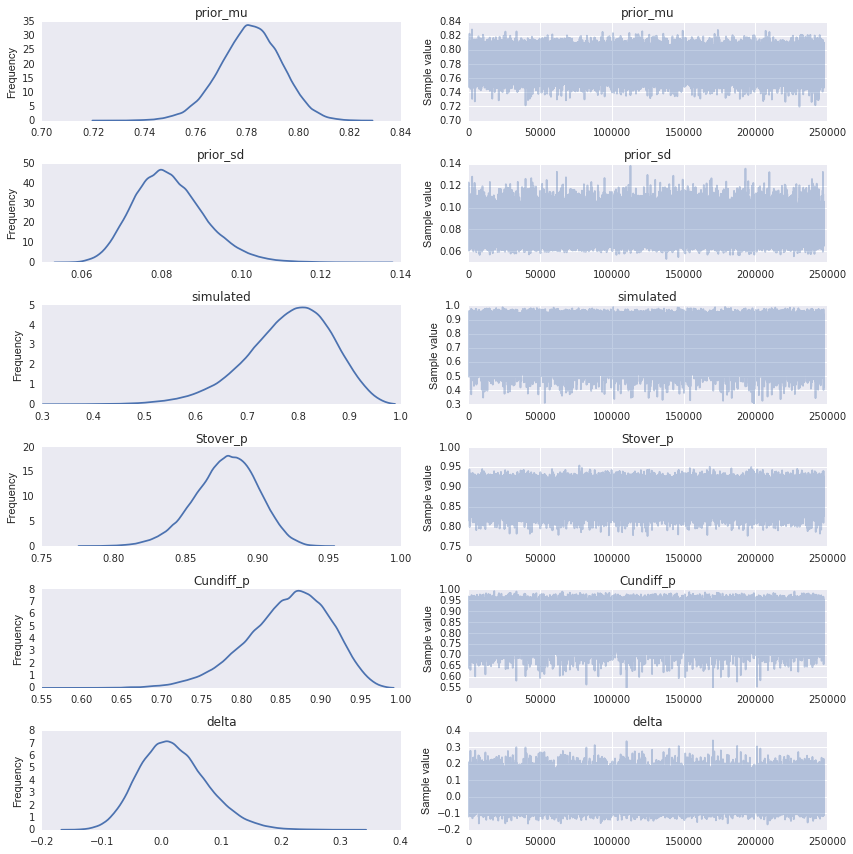

In [137]:
pm.traceplot(burned_trace)

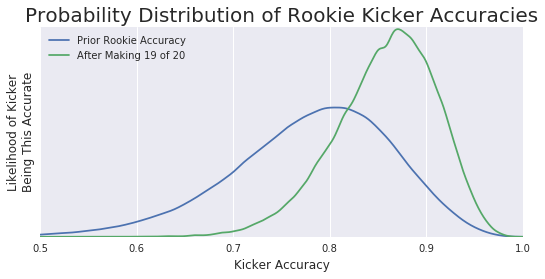

In [138]:
plt.figure(figsize=[8,4])
ax=(pd.Series(burned_trace['simulated'])).plot(kind='kde', label='Prior Rookie Accuracy')
(pd.Series(burned_trace['Cundiff_p'])).plot(kind='kde', ax=ax, label='After Making 19 of 20')

plt.legend(loc='upper left', fontsize=10)
plt.xlim([.5,1.])
plt.title('Probability Distribution of Rookie Kicker Accuracies', fontsize=20)
plt.yticks([])
plt.xlabel('Kicker Accuracy', fontsize=12)
plt.ylabel('Likelihood of Kicker\nBeing This Accurate', fontsize=12)
plt.tight_layout()

In [139]:
series = {}

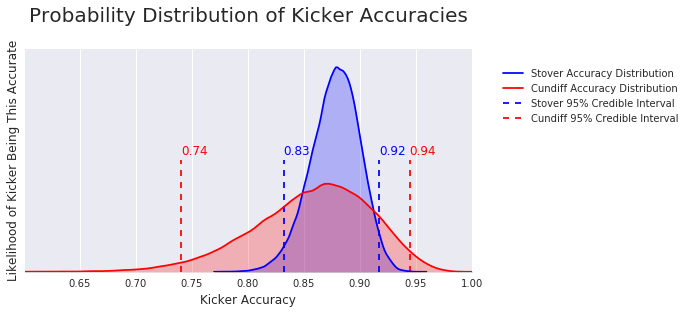

In [213]:
plt.figure(figsize=[8,4])
variables = ['Stover_p', 'Cundiff_p']
colors = {'Stover_p': 'blue', 'Cundiff_p': 'red', 'simulated': 'green'}


for var in variables:
    if var not in series: # Just in case I end up running this cell multiple times, no need to recreate these
        series[var] = pd.Series(burned_trace[var])
    sns.kdeplot(series[var], label=var[:-2]+' Accuracy Distribution', ax=plt.gca(), shade=True, color=colors[var])
    plt.vlines(series[var].quantile(.025), 0,10, colors[var], 'dashed', label=var[:-2]+' 95% Credible Interval')
    plt.text(series[var].quantile(.025), 10.5, '{:.2f}'.format(series[var].quantile(.025)),color= colors[var])
    plt.vlines(series[var].quantile(.975), 0,10, colors[var], 'dashed')
    plt.text(series[var].quantile(.975), 10.5, '{:.2f}'.format(series[var].quantile(.975)),color= colors[var])
#     (pd.Series(burned_trace['Cundiff_p'])).plot(kind='kde', ax=ax, label='Cundiff Accuracy Distribution')
#     (pd.Series(burned_trace['simulated'])).plot(kind='kde', ax=ax, label='Prior Rookie Accuracy Distribution')

    
plt.legend(loc='upper left', bbox_to_anchor=[1.05, .95], fontsize=10)
plt.xlim([.601,1.])
plt.title('Probability Distribution of Kicker Accuracies\n', fontsize=20)
plt.yticks([])
plt.xlabel('Kicker Accuracy', fontsize=12)
plt.ylabel('Likelihood of Kicker Being This Accurate', fontsize=12)

In [141]:
print "Stover 95% Credible Interval:", series['Stover_p'].quantile(.025),series['Stover_p'].quantile(.975)
print "Cundiff 95% Credible Interval:", series['Cundiff_p'].quantile(.025),series['Cundiff_p'].quantile(.975)

Stover 95% Credible Interval: 0.832010176318 0.917461128206
Cundiff 95% Credible Interval: 0.740657774752 0.944683102188


### Short exploration of an interesting way to color graphs - didn't end up using this, though

In [164]:
stover_hist = np.histogram(burned_trace['Stover_p'], bins=np.arange(0,1,.005))
cundiff_hist = np.histogram(burned_trace['Cundiff_p'], bins=np.arange(0,1,.005))

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

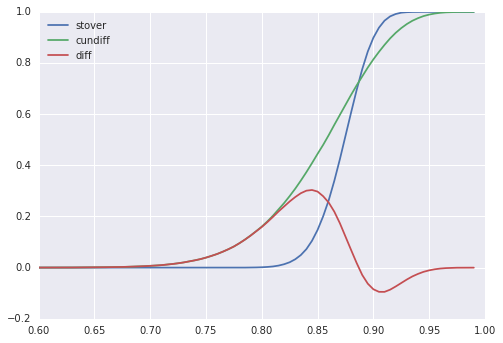

In [182]:
cumsums = pd.DataFrame(index=stover_hist[1][:-1])
cumsums['stover'] = stover_hist[0].cumsum() / float(len(burned_trace['Stover_p']))
cumsums['cundiff'] = cundiff_hist[0].cumsum() / float(len(burned_trace['Cundiff_p']))


cumsums['diff'] = cumsums.cundiff - cumsums.stover
cumsums.plot(xlim=[.6,1])
# plt.plot(stover_hist[1][:-1], stover_hist[0].cumsum())
sns.color_palette()

## These probability distributions can answer more specific questions about our subjective confidences:

### A) How likely do we think Stover's accuracy is higher than Cundiff's?
### B) How likely is Stover at least three percent better than Cundiff?
### C) How likely is each kicker's accuracy over 92%?

---

### A) How likely do we think Stover's accuracy is higher than Cundiff's?


In [185]:
chance_stover_better = (burned_trace['Cundiff_p'] - burned_trace['Stover_p'] < 0).mean() * 100
print "We think there's a {:.2f}% chance Stover has higher accuracy.".format(chance_stover_better)

We think there's a 61.86% chance Stover has higher accuracy.


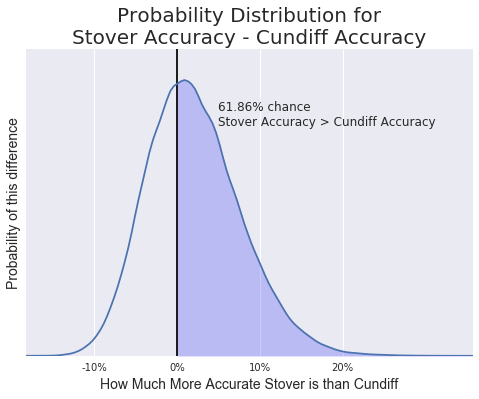

In [190]:
ax = sns.kdeplot(burned_trace['Stover_p'] - burned_trace['Cundiff_p'])
points = pd.DataFrame(ax.get_lines()[0].get_xydata())
ax.fill_between(points[0], points[1], where=points[0]>=0, alpha=.2, color="blue")

plt.title('Probability Distribution for\nStover Accuracy - Cundiff Accuracy', fontsize=20)
plt.xlabel('How Much More Accurate Stover is than Cundiff', fontsize=14)
plt.yticks([])
plt.ylabel('Probability of this difference', fontsize=14)
plt.xticks([-.3, -.2,-.1,0,.1,.2], ['-30%', '-20%','-10%','0%','10%','20%'])
plt.vlines(0,0,8)
plt.text(.05, 6, "{:.2f}% chance\nStover Accuracy > Cundiff Accuracy".format(chance_stover_better))

### B) How likely is Stover at least three percent better than Cundiff?

In [193]:
chance_stover_better_by_three = (burned_trace['Stover_p'] - burned_trace['Cundiff_p'] > 0.03).mean() * 100
print "We think there's a {:.2f}% chance Stover is at least 3% more accurate than Cundiff.".format(chance_stover_better_by_three)

We think there's a 40.73% chance Stover is at least 3% more accurate than Cundiff.


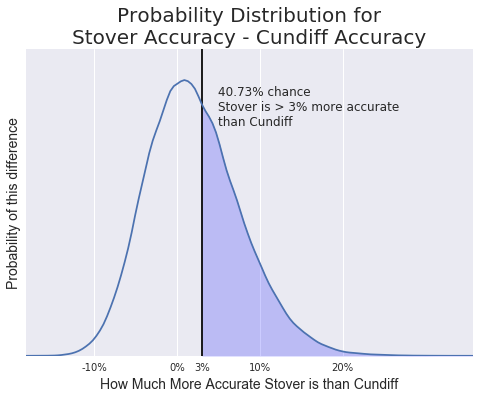

In [195]:
ax = sns.kdeplot(burned_trace['Stover_p'] - burned_trace['Cundiff_p'])
points = pd.DataFrame(ax.get_lines()[0].get_xydata())
ax.fill_between(points[0], points[1], where=points[0]>=0.03, alpha=.2, color="blue")

plt.title('Probability Distribution for\nStover Accuracy - Cundiff Accuracy', fontsize=20)
plt.xlabel('How Much More Accurate Stover is than Cundiff', fontsize=14)
plt.yticks([])
plt.ylabel('Probability of this difference', fontsize=14)
plt.xticks([-.3, -.2,-.1,0,.03,.1,.2], ['-30%', '-20%','-10%', '0%','3%', '10%','20%'])
plt.vlines(.03, 0,8)
plt.text(.05, 6, "{:.2f}% chance\nStover is > 3% more accurate\nthan Cundiff".format(chance_stover_better_by_three))

### C) How likely is each kicker's accuracy over 92%?


In [204]:
stover_great = (burned_trace['Stover_p'] > .92).mean()*100
cundiff_great = (burned_trace['Cundiff_p'] > .92).mean()*100

print "Stover: ", stover_great
print "Cundiff: ",cundiff_great
print "Cundiff is ", cundiff_great / stover_great," times more likely to be great (>92% accuracy)"

Stover:  1.74919354839
Cundiff:  10.3608870968
Cundiff is  5.92323651452  times more likely to be great (>92% accuracy)


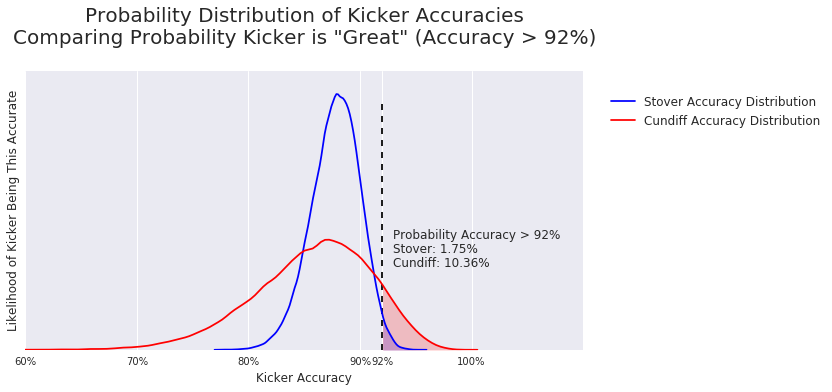

In [211]:
plt.figure(figsize=[10,5])
ax=sns.kdeplot(series['Stover_p'], label='Stover Accuracy Distribution', color='blue')
sns.kdeplot(series['Cundiff_p'], ax=ax,label='Cundiff Accuracy Distribution', color='red')
plt.legend(loc='upper left')
plt.xticks([.6,.7,.8,.9,.92,1], ['60%','70%','80%','90%','92%', '100%'])


points_0 = pd.DataFrame(ax.get_lines()[0].get_xydata())
points_1 = pd.DataFrame(ax.get_lines()[1].get_xydata())
ax.fill_between(points_0[0], points_0[1], where=points_0[0]>=0.92, alpha=.2, color="blue")
ax.fill_between(points_1[0], points_1[1], where=points_1[0]>=0.92, alpha=.2, color="red")

plt.vlines(.92, 0,18, linestyles='dashed')

plt.text(.93, 8, "Probability Accuracy > 92%")
plt.text(.93, 7, "Stover: {:.2f}%".format(stover_great))
plt.text(.93, 6, "Cundiff: {:.2f}%".format(cundiff_great))
plt.legend(loc='upper left', bbox_to_anchor=[1.03,.95], fontsize=12)
plt.xlim([.6,1.1])
plt.title('Probability Distribution of Kicker Accuracies\nComparing Probability Kicker is "Great" (Accuracy > 92%)\n', fontsize=20)
plt.yticks([])
plt.xlabel('Kicker Accuracy', fontsize=12)
plt.ylabel('Likelihood of Kicker Being This Accurate', fontsize=12)